In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
from pvanalytics import quality
from pvlib import temperature

## Importing data

In [2]:
#readcsv elns
#readcsv
df = pd.read_csv("df_hourly")

if not isinstance(df["Timestamp"], pd.DatetimeIndex):
        df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df.set_index("Timestamp", inplace=True)

In [3]:
df.columns

Index(['PT JKM325 nr 1 [°C]', 'PT JKM325 nr 2 [°C]', 'PT JKM325 nr 3 [°C]',
       'PT JKM335 nr 1 [°C]', 'PT JKM335 nr 2 [°C]', 'PT JKM335 nr 3 [°C]',
       'PT REC nr 1 [°C]', 'PT REC nr 2 [°C]', 'PT REC nr 3 [°C]',
       'PT SunP nr 1 [°C]', 'PT SunP nr 2 [°C]', 'PT SunP nr 3 [°C]',
       'PT Talesun 1 [°C]', 'PT Talesun 2 [°C]', 'PT Talesun 3 [°C]',
       'PT Talesun FrLess 1 [°C]', 'PT Talesun FrLess 2 [°C]',
       'PT Talesun FrLess 3 [°C]', 'Irradiance (IRR Hor - SunP) [W/m²]',
       'Irradiance (IRR Plan - SunP) [W/m²]',
       'Irradiance (IRR Plan - Talesun) [W/m²]',
       'Irradiance (IRR Plan - JKM325) [W/m²]',
       'Irradiance (IRR Plan - JKM335) [W/m²]',
       'Irradiance (SMP10 Sunpower plan) [W/m²]',
       'Irradiance (SMP10 Sunpower horisontal) [W/m²]',
       'Irradiance (SMP10 Talesun albedo) [W/m²]',
       'Irradiance (SMP10 Talesun plan) [W/m²]',
       'Irradiance (KippZonen SMP10 20201023) [W/m²]',
       'WS500_1_Air pressure abs [hPa]', 'WS500_1_Air

### Plotting function

In [4]:
import matplotlib.dates as mdates

def plot_comparison(x, temp_model, temp_measured, module_name):
    if not isinstance(x, pd.DatetimeIndex):
        x = pd.to_datetime(x)

    #x = x.asfreq('h')

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9, 6), gridspec_kw={'height_ratios': [2, 1]}, sharex=True)
    ax1.set_title(f"Model prediction and measured temperature for {module_name}")
    ax1.plot(x, temp_model, label="SAPM module temperature")
    ax1.plot(x, temp_measured, label="Measured module temperature")
    ax1.set_ylabel("[°C]")
    #ax2.set_title("Residuals")
    ax2.plot(x, temp_model-temp_measured)
    ax2.set_ylabel("Residuals [°C]")
    ax2.axhline(0, c="grey", linestyle=":")
    ax1.legend()
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())  
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
    #plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right") 
    plt.tight_layout()
    plt.show()

## Testing some pvlib-models

Calculates the back surface temperature per the Sandia Array Performance Model, where the module temperature is given by


$T_{m} = E \cdot exp(a+b \cdot WS) + T_a$

(Eq. 11 i artikkelen jeg har lagret som SAPM model)

Inputs to the model are plane-of-array irradiance $E$ (W/m2) and ambient air temperature $T_a$ (C). Model outputs are surface temperature at the back of the module $T_m$ and cell temperature $T_C$. Model parameters depend both on the module construction and its mounting.(See table)

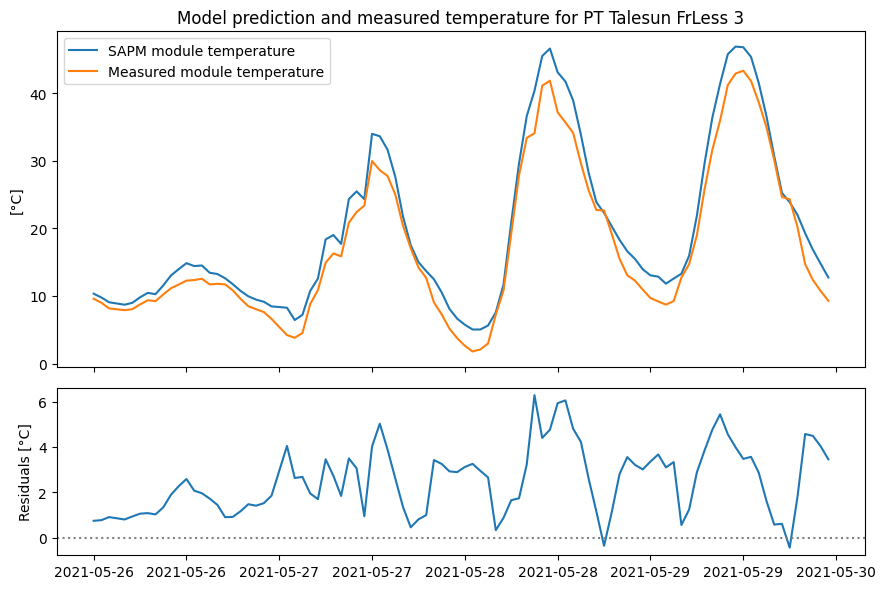

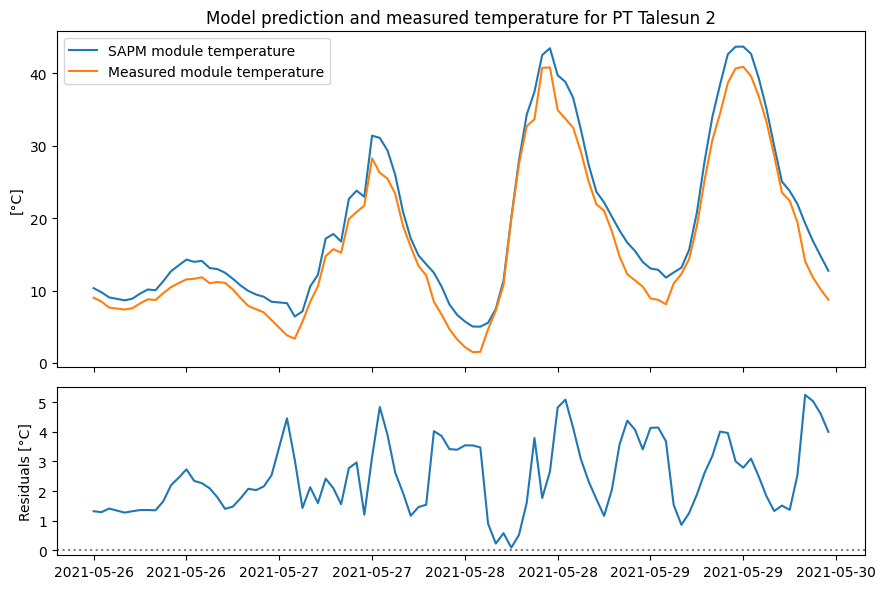

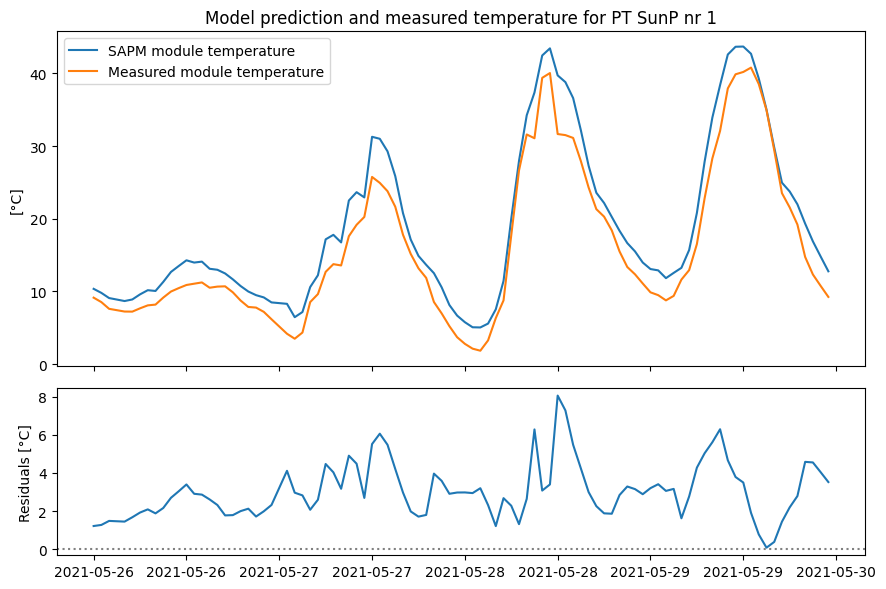

In [5]:
#Sandia Array Performance Model

#glass/glass: open rack   a=-3.47   b=-0.0594  
temp_sapm_cell = temperature.sapm_module(df["Irradiance (IRR Plan - Talesun) [W/m²]"], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"], -3.47, -0.0594)
#glass/polymer: open rack   a=-3.56   b=-0.075  
temp_sapm_cell2 = temperature.sapm_module(df["Irradiance (IRR Plan - Talesun) [W/m²]"], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"], -3.56, -0.075)
#glass/polymer: open rack   a=-3.56   b=-0.075  
temp_sapm_cell3 = temperature.sapm_module(df["Irradiance (IRR Plan - SunP) [W/m²]"], df["WS500_1_Temperature [°C]"], df["WS500_1_Wind speed [m/s]"], -3.56, -0.075)

#Since we used the parameters for glass-glass in the model we want to compare with the 
#measured temperature from the Talesun bifacial without frame -> glass-glass
datea = '2021-05-26'
dateb = '2021-05-29'
plot_comparison(df.loc[datea:dateb].index, temp_sapm_cell.loc[datea:dateb], df["PT Talesun FrLess 3 [°C]"].loc[datea:dateb], "PT Talesun FrLess 3")
plot_comparison(df.loc[datea:dateb].index, temp_sapm_cell2.loc[datea:dateb], df["PT Talesun 2 [°C]"].loc[datea:dateb], "PT Talesun 2")
plot_comparison(df.loc[datea:dateb].index, temp_sapm_cell3.loc[datea:dateb], df['PT SunP nr 1 [°C]'].loc[datea:dateb], "PT SunP nr 1")

## Mean bias error

In [6]:
def MBE(model_results, measured_temp): 
    df_temp = pd.DataFrame({'model_results': model_results, 'measured_temp': measured_temp})
    df_temp = df_temp.dropna(how="any")

    #Calculating RMSE
    mbe = (1/len(df_temp["model_results"])) * np.sum(df_temp["model_results"] - df_temp["measured_temp"]) #np.sqrt(((df_temp["model_results"] - df_temp["measured_temp"])**2).mean())
    return mbe

In [7]:
#Bifacial
print(MBE(temp_sapm_cell, df["PT Talesun FrLess 3 [°C]"]))
print(MBE(temp_sapm_cell2, df["PT Talesun 2 [°C]"]))
#Monofacial
print(MBE(temp_sapm_cell3, df['PT SunP nr 1 [°C]']))

1.798776901298513
2.0242674103729676
2.4429892234433175


### Looking into error

In [8]:
#RMSE
def rmse(model_results, measured_temp):
    #Creating 
    df_temp = pd.DataFrame({'model_results': model_results, 'measured_temp': measured_temp})
    df_temp = df_temp.dropna(how="any")

    #Calculating RMSE
    rmse = np.sqrt(((df_temp["model_results"] - df_temp["measured_temp"])**2).mean())
    return rmse

#Bifacial
print(rmse(temp_sapm_cell, df["PT Talesun FrLess 3 [°C]"]))
print(rmse(temp_sapm_cell2, df["PT Talesun 2 [°C]"]))
#Monofacial
print(rmse(temp_sapm_cell3, df['PT SunP nr 1 [°C]']))

2.6253944505723292
2.6272393600363513
2.9198706061435655


### Calculating and saving needed data for comparison

In [9]:
temp_sapm1 = temp_sapm_cell2
temp_sapm2 = temp_sapm_cell2
temp_sapm3 = temp_sapm_cell2
temp_sapm4 = temp_sapm_cell2
temp_sapm5 = temp_sapm_cell
temp_sapm6 = temp_sapm_cell2

In [10]:
module_names = ["PT JKM325 nr 3", "PT JKM335 nr 3", "PT SunP nr 2", "PT REC nr 3", "PT Talesun FrLess 1",  "PT Talesun 3"]

MBE1 = MBE(temp_sapm1, df["PT JKM325 nr 3 [°C]"])
MBE2 = MBE(temp_sapm2, df["PT JKM335 nr 3 [°C]"])
MBE3 = MBE(temp_sapm3, df['PT SunP nr 2 [°C]'])
MBE4 = MBE(temp_sapm4, df['PT REC nr 3 [°C]'])
MBE5 = MBE(temp_sapm5, df["PT Talesun FrLess 1 [°C]"])
MBE6 = MBE(temp_sapm6, df["PT Talesun 3 [°C]"])

In [11]:
RMSE1 = rmse(temp_sapm1, df["PT JKM325 nr 3 [°C]"])
RMSE2 = rmse(temp_sapm2, df["PT JKM335 nr 3 [°C]"])
RMSE3 = rmse(temp_sapm3, df['PT SunP nr 2 [°C]'])
RMSE4 = rmse(temp_sapm4, df['PT REC nr 3 [°C]'])
RMSE5 = rmse(temp_sapm5, df["PT Talesun FrLess 1 [°C]"])
RMSE6 = rmse(temp_sapm6, df["PT Talesun 3 [°C]"])

In [12]:
results = pd.DataFrame({
    "Module": module_names,
    "RMSE": [RMSE1, RMSE2, RMSE3, RMSE4, RMSE5, RMSE6],
    "MBE": [MBE1, MBE2, MBE3, MBE4, RMSE5, RMSE6]
})

In [13]:
results.to_csv('SAPM_results.csv', index=False)